In [1]:
import sys
sys.path.append('/Users/omarschall/vanilla-rtrl/')
import numpy as np
from network import RNN
from simulation import Simulation
from gen_data import *
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    pass
from optimizers import *
from analysis_funcs import *
from learning_algorithms import *
from functions import *
from itertools import product
import os
import pickle
from copy import deepcopy
from scipy.ndimage.filters import uniform_filter1d
from sklearn import linear_model
from state_space import State_Space_Analysis
from dynamics import find_slow_points
%matplotlib notebook

In [7]:
task = Flip_Flop_Task(3, 0.05, tau_task=10)
data = task.gen_data(10000, 10000)

In [16]:
n_in = task.n_in
n_hidden = 128
n_out = task.n_out

W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
W_FB = np.random.normal(0, np.sqrt(1/n_out), (n_out, n_hidden))
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 0.05

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

optimizer = Stochastic_Gradient_Descent(lr=0.0005, clip_norm=1.0)
SG_optimizer = Stochastic_Gradient_Descent(lr=0.001)

learn_alg = Efficient_BPTT(rnn, T_truncation=10, L2_reg=0.001)
#learn_alg = RTRL(rnn)

comp_algs = []
monitors = ['rnn.loss_', 'learn_alg.rec_grads-norm']

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        comp_algs=comp_algs,
        monitors=monitors,
        verbose=True,
        check_accuracy=False,
        check_loss=True)

Progress: 10.0% complete 
Time Elapsed: 0.5s 
Average loss: 0.09730586414705229 
Test loss: 0.9319739852613406 

Progress: 20.0% complete 
Time Elapsed: 1.5s 
Average loss: 0.1632803997296023 
Test loss: 0.9042221892508331 

Progress: 30.0% complete 
Time Elapsed: 2.5s 
Average loss: 0.1027631483131097 
Test loss: 0.5568226006795148 

Progress: 40.0% complete 
Time Elapsed: 3.5s 
Average loss: 0.07542703751535319 
Test loss: 0.9727252066729365 

Progress: 50.0% complete 
Time Elapsed: 4.5s 
Average loss: 0.07173459589535575 
Test loss: 0.9300821914912598 

Progress: 60.0% complete 
Time Elapsed: 5.4s 
Average loss: 0.08698541878311145 
Test loss: 1.4449404713447254 

Progress: 70.0% complete 
Time Elapsed: 6.4s 
Average loss: 0.06677132386564104 
Test loss: 0.7059606582389906 

Progress: 80.0% complete 
Time Elapsed: 7.4s 
Average loss: 0.08369028486677078 
Test loss: 1.0904037266916364 

Progress: 90.0% complete 
Time Elapsed: 8.4s 
Average loss: 0.07653111606797355 
Test loss: 0.8050

<IPython.core.display.Javascript object>


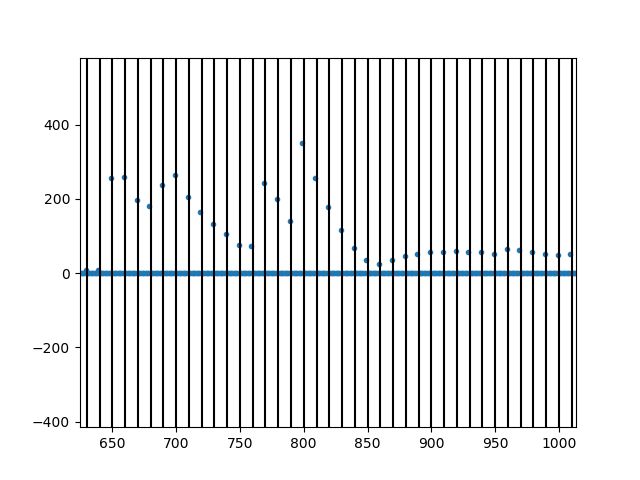

In [18]:
%matplotlib notebook
plt.figure()
plt.plot(sim.mons['learn_alg.rec_grads-norm'], '.')
#plt.ylim([0, 1])
for i in range(10000):
    if i % 10 == 0:
        plt.axvline(x=i, color='k')

In [ ]:
# Save network
#network_name = 'j_boxman'
network_name = 'new_network'
with open(os.path.join('good_ones/', network_name), 'wb') as f:
    pickle.dump(rnn, f)

In [ ]:
#Fine tune
optimizer = Stochastic_Gradient_Descent(lr=0.00001, clip_norm=1.0)
#learn_alg = Efficient_BPTT(rnn, T_truncation=200, L2_reg=0.001)
sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        comp_algs=comp_algs,
        monitors=monitors,
        verbose=True,
        check_accuracy=False,
        check_loss=True)

In [ ]:
plt.figure()
plt.imshow(rnn.W_rec)
plt.colorbar()

(-2.0983985669063112,
 1.8110419834437768,
 -1.1000000000000001,
 1.1000000000000001)

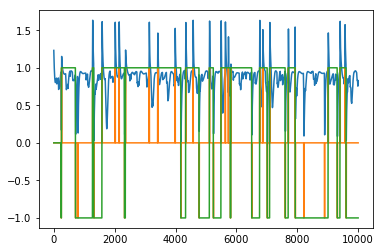

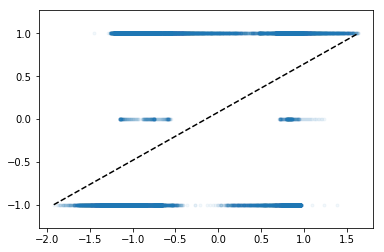

In [6]:
#Test run
test_sim = Simulation(rnn)
test_sim.run(data,
             mode='test',
             monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
             verbose=False)
fig = plt.figure()

plt.plot(test_sim.mons['rnn.y_hat'][:,1])
plt.plot(data['test']['X'][:,1])
plt.plot(data['test']['Y'][:,1])
#plt.xlim([0, 1000])
plt.figure()
x = test_sim.mons['rnn.y_hat'].flatten()
y = data['test']['Y'].flatten()
plt.plot(x, y, '.', alpha=0.05)
plt.plot([np.amin(x), np.amax(x)],
          [np.amin(y), np.amax(y)], 'k', linestyle='--')
plt.axis('equal')

In [ ]:
from importlib import reload
import state_space as ss
reload(ss)


In [ ]:
%matplotlib notebook

In [ ]:
ssa = State_Space_Analysis(test_sim.mons['rnn.a'][:10000], n_PCs=3)

In [ ]:
ssa.plot_in_state_space(test_sim.mons['rnn.a'], '.', alpha=0.002)
ssa.fig.axes[0].set_xlim([-0.6, 0.6])
ssa.fig.axes[0].set_ylim([-0.6, 0.6])
ssa.fig.axes[0].set_zlim([-0.8, 0.8])

In [ ]:
for i in range(8):
    col = 'C{}'.format(i+1)
    ssa.plot_in_state_space(A[i,:-1,:], color=col)
    ssa.plot_in_state_space(A[i,-1,:].reshape((1,-1)), 'x', color=col)

In [ ]:
ssa.clear_plot()

In [ ]:
plt.figure()
plt.imshow(a_values.T, aspect='auto')

In [ ]:
import multiprocessing as mp
from importlib import reload
import dynamics as dyn
reload(dyn)
pool = mp.Pool(mp.cpu_count())
results = pool.map_async(dyn.find_slow_points, zip([test_sim]*8, range(8)))
result = results.get()
pool.close()
A = np.array([result[i][0] for i in range(8)])
speeds = np.array([result[i][1] for i in range(8)])

In [ ]:
plt.figure()
plt.plot(speeds[6])

In [ ]:
A.shape

In [ ]:
a_values[0].shape
A = np.array(a_values)

In [ ]:
A.shape

In [ ]:
ssa.V[:,:3].T.shape

In [ ]:
plt.figure()
plt.plot(ssa.S, '.')

In [ ]:
plt.figure()
plt.hist(ssa.V[:,:3].T.dot(test_sim.mons['rnn.a'].T)[2], bins=100)

In [ ]:
from dynamics import run_autonomous_sim
sim = run_autonomous_sim()

In [ ]:
np.inf > 109000

In [ ]:
import multiprocessing as mp
from dynamics import find
N_seeds = 1
N_iters = 2000000
LR = 0.000001
test_data = test_sim.mons['rnn.a']
speeds = np.zeros((N_seeds, N_iters))
norms = np.zeros((N_seeds, N_iters))
a_values = np.zeros((N_seeds, N_iters, rnn.n_h))
for i in range(N_seeds):
    i_a = np.random.randint(test_data.shape[0])
    rnn.reset_network(a=test_data[i_a])
    for j in range(N_iters):
        speeds[i, j] = rnn.get_network_speed()
        norms[i, j] = norm(rnn.a)
        rnn.a -= LR * rnn.get_network_speed_gradient()
        a_values[i, j, :] = np.copy(rnn.a)

In [ ]:
plt.figure()
i_seed = 0
plt.plot(speeds[i_seed])
#plt.plot(norms[i_seed])
plt.legend(['Speed', 'Norm'])
#plt.ylim([0, 0.2])